In [1]:
import pandas as pd
import numpy as np
import time
import requests
from bs4 import BeautifulSoup
from IPython.display import Markdown, display,HTML,Image
import string
from z3 import *
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
url='https://www.janestreet.com/puzzles/eldrow-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Puzzle as published \n'+url))

HTML(str(soup.find('div', {'class' :'inner-wrapper'})))

### Puzzle as published 
https://www.janestreet.com/puzzles/eldrow-index/

In [3]:
xl = pd.read_csv('EldrowWordlist.csv')
data = xl['words'].to_list()
letters = set([i for i in string.ascii_uppercase])
len(data)

2314

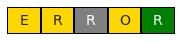

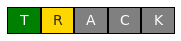

In [4]:
# Some code to visualise the solutions
def scorer(w,t):
    word = np.array([i for i in w])
    target =np.array([i for i in t])
    fixed =  word==target   
    soln = np.zeros(5)
    for i,l in enumerate(word):
        if l == target[i]:
            soln[i]=2
        elif l in target[fixed==False]:            
            soln[i]=1
            for n in range(5):
                if fixed[n]==False and target[n] == l:
                    fixed[n]= True
                    break
                    
    score_cols = ListedColormap(['grey','gold','green'])
    fig,ax = plt.subplots(1,1,figsize=(3,0.5))
    ax = sns.heatmap([soln],annot=np.array([[i for i in word]]),fmt='',
                     cbar=False,cmap=score_cols,linecolor='k',linewidth=2,
                     annot_kws={"fontsize":14},vmin=0,vmax=2)
    ax.axis('off')
    plt.show()
    return set(word[soln==0])-set(word[soln!=0])
        
    
x = scorer("ERROR","ROVER")
x = scorer('TRACK','TIGER')

In [5]:
#code to search for chains. Not perfect, still gets confused on double letters.

def in_word(l,word,test_word,target):
    return Or([If(test_word[i] !=target[i],w==l,False) for i,w in enumerate(word)])

def not_in_word(l,word,test_word,target):
    return And([If(test_word[i] !=target[i],w!=l,True) for i,w in enumerate(word)])

def solve(allowed,N,forced=[]):
    start= time.time()
    letters ={e:i for i,e in enumerate([i for i in string.ascii_uppercase])}
    lett = [i for i in string.ascii_uppercase]        
          
    encode = [[letters[l] for l in w] for w in allowed]
    words = [IntVector("x"+str(i),5) for i in range(N)]
    s = Tactic('pqffd').solver()
         
    s += [And(e>=0,e<=25) for _,e in np.ndenumerate(words)]
    s += [Or([And([w[i] == int(l) for i,l in enumerate(e)]) for e in encode]) for w in words]
    s += Distinct([Sum([e*(100**i) for i,e in enumerate(w)]) for w in words])
    
    if len(forced) > 0:
        for i,e in enumerate(forced[::-1]):
            s += [l == letters[e[n]] for n,l in enumerate(words[N-i-1])]

    for l in range(5):
        for w in range(N-1):
            # equal & not equal
            cur_let = words[w][l]
            tar_let = words[-1][l]
            nxt_let = [words[x][l] for x in range(w+1,N-1)]
            
            s += Implies(cur_let == tar_let,And([cur_let == x for x in nxt_let]))
                         
            s += Implies(cur_let != tar_let,And([cur_let != x for x in nxt_let]))
            
            s += Implies(cur_let != tar_let, Implies(in_word(cur_let,words[-1],words[w],words[-1]),
                         in_word(cur_let,words[w+1],words[w],words[-1])))
            
            s += Implies(cur_let != tar_let,Implies(not_in_word(cur_let,words[-1],words[w],words[-1]),
                         And([not_in_word(cur_let,words[x],words[w],words[-1]) for x in range(w+1,N-1)])))
        
    print("Setup after {:.2f} secs".format(time.time()-start))

    if s.check() == sat:
        m = s.model()
        as_word = lambda x:"".join([lett[n] for n in x])
        evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
        print(",".join([as_word(i) for i in evalu(words)]))
        print("Solved after {:.2f} secs".format(time.time()-start))
        return [as_word(i) for i in evalu(words)]
    else:
        print("Failed")
        return []

In [6]:
# Search space is huge. After a lot of effort found that there were some endings that gave long sequences that narrowed things down a lot
# IGHT is the longest list but doesn't give the longest full chain. OWER gives a lot of similar words *O*ER and ***ER so doesn't
# use up spare letters as quickly. Had high hopes for "ILLY" but didn't give anything better

x,y = 1,5
test = np.unique([i[x:y] for i in data],return_counts=True)
inds = test[1].argsort()
display([i for i in zip(test[0][inds][:-10:-1],test[1][inds][:-10:-1])])

[('IGHT', 9),
 ('OUND', 8),
 ('ATCH', 7),
 ('OWER', 7),
 ('ASTE', 6),
 ('ATTY', 6),
 ('ILLY', 6),
 ('AUNT', 6),
 ('ULLY', 5)]

The sequence OWER appears 7 times
Words are :['COWER', 'LOWER', 'MOWER', 'POWER', 'ROWER', 'SOWER', 'TOWER']
Setup after 18.31 secs
QUEUE,INNER,GAZER,ODDER,FOYER,JOKER,BOXER,HOVER,WOOER,COWER,LOWER,MOWER,POWER,ROWER,SOWER,TOWER
Solved after 36.35 secs


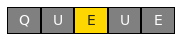

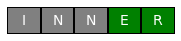

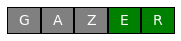

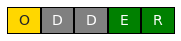

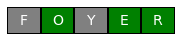

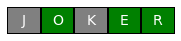

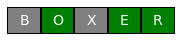

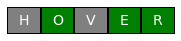

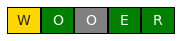

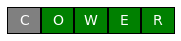

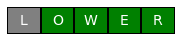

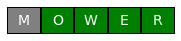

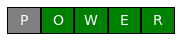

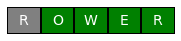

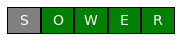

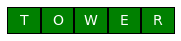

In [7]:
a,b,x,y = 0,0,1,5
ending ='OWER'
long = [i for i in data if i[a:b]+i[x:y] ==ending]
print("The sequence {} appears {} times".format(ending,len(long)))
print("Words are :{}".format(long))
x = solve(data,16,forced=long)
exclude = []
for i in x:
    if i in data and np.all([j not in exclude for j in i]):
        exclude += list(scorer(i,x[-1]))
    else:
        print("ERROR")

In [8]:
url='https://www.janestreet.com/puzzles/eldrow-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Solution as published \n'+url))
HTML(str(soup.find('div', {'class' :'inner-wrapper'})))

### Solution as published 
https://www.janestreet.com/puzzles/eldrow-solution/

In [9]:
a,b,x,y = 0,1,2,5
test = np.unique([i[a:b]+i[x:y] for i in data],return_counts=True)
inds = test[1].argsort()
display([i for i in zip(test[0][inds][:-10:-1],test[1][inds][:-10:-1])])

[('SORE', 6),
 ('SARE', 5),
 ('SACK', 5),
 ('SOOP', 5),
 ('SOUT', 5),
 ('SILL', 4),
 ('SEAR', 4),
 ('SELL', 4),
 ('SUNK', 4)]

The sequence OUND appears 8 times
Words are :['BOUND', 'FOUND', 'HOUND', 'MOUND', 'POUND', 'ROUND', 'SOUND', 'WOUND']
Setup after 14.85 secs
LEVEL,AXION,KNOCK,JUNTO,YOUNG,BOUND,FOUND,HOUND,MOUND,POUND,ROUND,SOUND,WOUND
Solved after 21.73 secs


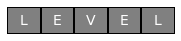

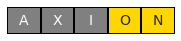

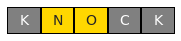

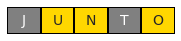

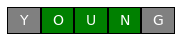

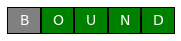

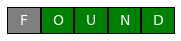

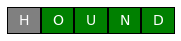

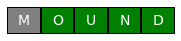

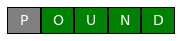

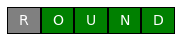

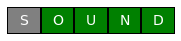

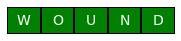

In [10]:
a,b,x,y = 0,0,1,5
ending ='OUND'
long = [i for i in data if i[a:b]+i[x:y] ==ending]
print("The sequence {} appears {} times".format(ending,len(long)))
print("Words are :{}".format(long))

x = solve(data,13,forced=long)
exclude = []
for i in x:
    if i in data and np.all([j not in exclude for j in i]):
        exclude += list(scorer(i,x[-1]))
    else:
        print("ERROR")

The sequence IGHT appears 9 times
Words are :['EIGHT', 'FIGHT', 'LIGHT', 'MIGHT', 'NIGHT', 'RIGHT', 'SIGHT', 'TIGHT', 'WIGHT']
Setup after 14.81 secs
PUPPY,OVOID,KHAKI,HITCH,EIGHT,FIGHT,LIGHT,MIGHT,NIGHT,RIGHT,SIGHT,TIGHT,WIGHT
Solved after 15.80 secs


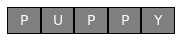

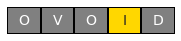

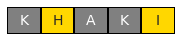

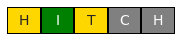

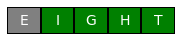

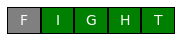

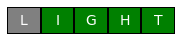

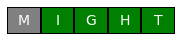

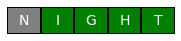

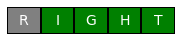

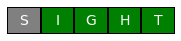

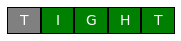

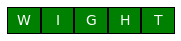

In [11]:
a,b,x,y = 0,0,1,5
ending ='IGHT'
long = [i for i in data if i[a:b]+i[x:y] ==ending]
print("The sequence {} appears {} times".format(ending,len(long)))
print("Words are :{}".format(long))

x = solve(data,13,forced=long)
exclude = []
for i in x:
    if i in data and np.all([j not in exclude for j in i]):
        exclude += list(scorer(i,x[-1]))
    else:
        print("ERROR")